In [13]:
import numpy as np
import pandas as pd
from scipy.io import *
from pylab import *
from pandas import DataFrame as df
import scipy
from PIL import Image
# import random
from scipy import stats
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from scipy.spatial import distance

In [14]:
FPPs = loadmat('Matrix120.mat')['s'][0]
communitiest = loadmat('Cluster120.mat')['b'][0]


In [15]:
# for i in range(len(FPP)):
#     FPP_= FPP[i].reshape(len(FPP[i]), 51, 20)
#     for j in range(len(FPP_)):
#         title('Rat %i FPP %i'%(i+1,j+1 ))
#         imshow(FPP_[j],extent=[-np.pi, np.pi, 20, 120],aspect='auto' )
#         ylabel('Frequencies(Hz)')
#         xlabel('Phase')
#         colorbar()
# #         savefig('Rat%i_FPP_%i'%(i+1, j+1))
#         show()

In [16]:
def pearson_dist(x, y):
    r = stats.pearsonr(x, y)[0]
    return (1 - r) / 2

def kmeans_(FPP, k=3):
    # define a custom metric
    metric = distance_metric(type_metric.USER_DEFINED, func=pearson_dist)
    # carry out a km++ init
    initial_centers = kmeans_plusplus_initializer(FPP, k).initialize()
    # execute kmeans
    kmeans_instance = kmeans(FPP, initial_centers, metric=metric)
    # run cluster analysis
    kmeans_instance.process()
    # get clusts
    clusters = kmeans_instance.get_clusters()

    return clusters
                    

In [17]:
#  Get amount of clusters expected through community clustering
maxima=[]
for i in range(1,16, 2):
    maxima.append(np.mean(communitiest[i]))
PFC_k= round(np.mean(np.array(maxima)))
maxima2=[]
for i in range(0,16,2):
    maxima2.append(np.mean(communitiest[i]))
HPC_k=round(np.mean(np.array(maxima2)))


In [18]:
# Retrieve HMM clustering labels

pfc_clusters=[]
for i in range(1,16,2):
    rat = FPPs[i]
    c =PFC_k
    pfc_clusters.append(kmeans_(rat, k=c))
hpc_clusters=[]
for i in range(0,16,2):
    rat = FPPs[i]
    c =HPC_k
    hpc_clusters.append(kmeans_(rat, k=c))


In [19]:
def recluster(FPP, clusters, start=0, step=2):
    '''
    Input: all FPPs, cluster labels from kmeans, start and step point rat iteration
    Export: all clusters for all rats
    Retrieve the data within the clusters
    '''
    pls = []
    for i in range(start,16,step):
        cl_ = []
        for j in range(0,len(np.array(clusters[i//2]))):
            p=i
            cls_=[]
            F= FPP[i]
            cluster=F[np.array(clusters[i//2])[j]]
#             print(shape(cl_))
            cl_.append(cluster)
        pls.append(cl_)
    return pls

In [20]:
pls_pfc = recluster(FPPs, pfc_clusters, 1)
pls_hpc = recluster(FPPs, hpc_clusters)

/tmp/ipykernel_4000/3309523559.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range(0,len(np.array(clusters[i//2]))):
/tmp/ipykernel_4000/3309523559.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster=F[np.array(clusters[i//2])[j]]


In [32]:
def pearson_dist(x, y):
    r = stats.pearsonr(x, y)[0]
    return (1 - r) / 2

def pearsoncor(x, y):
    r = stats.pearsonr(x, y)[0]
    return r
def mahalobis(x, y, lr=False):
    m =list(zip(x, y))
    try:
        iv = np.linalg.inv(np.cov(m))
    except:
        iv = np.linalg.pinv(np.cov(m)) 
    return distance.mahalanobis(x, y,iv)
def lrratio(x):
    l=stats.norm.cdf(x)
    return 1-l
def intracor(clusters, FPP_k, pearsondist=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster
    Input: Singular FPP, mean of all FPP within cluster, distance function indicator
    '''
    intra = []
    for j in range(20):
        FPP_i=clusters[:,j]
        if mahalanobis:
            intra.append(mahalobis(FPP_i, FPP_k))
        elif pearsondist:
            intra.append(pearson_dist(FPP_i, FPP_k))
        #Default pearson cor
        else:
            intra.append(pearsoncor(FPP_i, FPP_k))
    return intra

def extracor(FPP_i, FPP_k, pearsondist=False,lr=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster and the other clusters
    Input: Singular FPP, mean of all FPP outside of clusters, distance function indicator
    '''
    extra=[]
    
    cluster = FPP_k.reshape(len(FPP_k),51, 20)
    cluster = np.mean(cluster, axis=0)
    FPP_k= np.mean(cluster, axis=1)
    for j in range(20):
        FPP_i=cluster[:,j]
        if mahalanobis or lr:
            extra.append(mahalobis(FPP_i, FPP_k))
        elif pearsondist:
            extra.append(pearson_dist(FPP_i, FPP_k))
        #Default pearson cor
        else:
            extra.append(pearsoncor(FPP_i, FPP_k))
    if lr:
        return np.nanmean(lrratio(extra))
    return np.nanmax(extra)

In [20]:
# def intraextra(pls):
#     cluster_in=[]
#     cluster_ex=[]
#     for i in range(8):

#         f= pls[i].copy()
#         extra=[]
#         intra=[]
#         for c in range(len(pls[i])):
#             cluster = np.array(pls[i][c]).reshape(len(pls[i][c]), 51, 20)
#             cluster= np.mean(cluster, axis=0)
#             f.pop(c)
#             FPP_k_mean = f.copy()
#             FPP_k = np.mean(cluster, axis=1)
#             intr=[]
#             extr = []
# #             print(shape(FPP_k), shape(f))
#             for j in range(20):
#                 FPP_i=cluster[:,j]
#                 intr.append(intracor(FPP_i, FPP_k))
#                 extr.append(extracor(FPP_i, FPP_k_mean[0]))
#             extra.append(max(extr))
#             intra.append(np.mean(intr))
#             f=pls[i].copy()
#         cluster_in.append(intra)
#         cluster_ex.append(extra)
#     return cluster_in, cluster_ex

In [39]:
def gamma_sort(pls, region, threshold = 0.95):
    '''
    Input: clusters for all rats, region and threshold for centroid of gamma
    Output:mean (res/results) of all FPP in clusters for all rats, significancies for all distance measures  
    Sort into gamma clusters, retrieve significance and plot
    note: when num>1 iterate over ex_clusters
    '''
    res=[]
    accuracy_ex=[]
    accuracy_in=[]
    M_accuracy_ex=[]
    M_accuracy_in=[]
    lr_accuracy =[]
    for j in range(len(pls)):
        cls_=np.array(pls[j])
        ex_clusters= list(cls_.copy())
        clusters = []
        in_acc=[]
        ex_acc=[]
        lr_acc=[]
        M_ex_clusters= list(cls_.copy())
        M_in_acc=[]
        M_ex_acc=[]
        lr_ex_clusters= list(cls_.copy())
        for i in range(len(cls_)):
            cluster =np.array(cls_[i])
            gamma_peak = threshold*max(np.array([np.max(c) for c in cluster]))
            cluster=cluster.reshape(len(cluster),51,20)
            masked_cluster =np.mean(cluster, axis=0)
            #Measure significance
            
            ex_clusters.pop(i)
            for c in range(len(ex_clusters)):
                #Pearson
                intra = np.nanmean(intracor(masked_cluster, np.mean(masked_cluster, axis=1)))
                extra=extracor(masked_cluster, np.array(ex_clusters[c]))
                in_acc.append(intra)
                ex_acc.append(extra)
                ex_clusters=list(cls_.copy())
                #mahalanobis
                M_ex_clusters.pop(i)
                M_intra = np.nanmean(intracor(masked_cluster, np.mean(masked_cluster, axis=1), mahalanobis=True))
                M_extra=extracor(masked_cluster, np.array(M_ex_clusters[c]), mahalanobis=True)
                M_in_acc.append(M_intra)
                M_ex_acc.append(M_extra)
                M_ex_clusters=list(cls_.copy())
                #Lratio
                lr_ex_clusters.pop(i)
                lr=extracor(masked_cluster, np.array(lr_ex_clusters[c]),lr=True)
                lr_acc.append(lr)
                lr_ex_clusters=list(cls_.copy())

            imshow(masked_cluster,extent=[-np.pi, np.pi, 120, 20],aspect='auto', cmap = 'hot' )
            ylabel('Frequencies(Hz)')    
            xlabel('Phase')
            colorbar()
            if j>=4:
                title('Rat %i cluster %i %s'%(j+2,i+1, region))

                savefig('freq120/kmeans/mean/Downsample2/Rat %i cluster %i %s'%(j+2,i+1, region))
            else:
                title('Rat %i cluster %i %s'%(j+1,i+1, region))
                savefig('freq120/kmeans/mean/Downsample2/Rat %i cluster %i %s'%(j+1,i+1, region))
            
            show()
            #show average bin
#             for c in range(20):
#                 imshow(np.array([av_cluster[:,c]]).T,aspect='auto' )
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 if j>=4:
#                     title('Rat %i cluster %i cycle %i'%(j+2,i+1, c+1 ))

#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+2,i+1, region, c+1))
#                 else:
#                     title('Rat %i cluster %i cycle %i'%(j+1,i+1, c+1))
#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+1,i+1, region, c+1)
#                 show()
#             l=random.choices(range(len(cluster)), k=3)
#             for f in l:
#                 imshow(cluster[f],extent=[-np.pi, np.pi, 120, 20],aspect='auto', cmap = 'hot')
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 xlabel('Phase')
#                 if j>=4:
#                     title('Rat %i cluster %i random sample %s'%(j+2,i+1, region))

# #                     savefig('Rat %i cluster %i random sample %i'%(j+2,i+1, f+1))
#                 else:
#                     title('Rat %i cluster %i random sample %s'%(j+1,i+1, region))
# #                     savefig('Rat %i cluster %i random sample %i'%(j+1,i+1, f+1))
#                 show()
            
            clusters.append(masked_cluster)
        accuracy_ex.append(ex_acc)
        accuracy_in.append(in_acc)
        M_accuracy_ex.append(M_ex_acc)
        M_accuracy_in.append(M_in_acc)
        lr_accuracy.append(lr_acc)
        res.append(clusters)
    return res, accuracy_ex, accuracy_in, M_accuracy_ex,M_accuracy_in,lr_accuracy

/tmp/ipykernel_4000/3284058585.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cls_=np.array(pls[j])


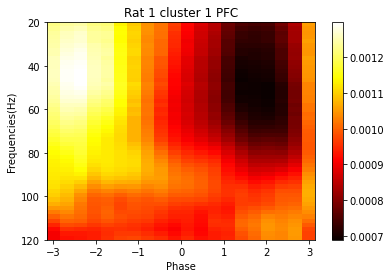

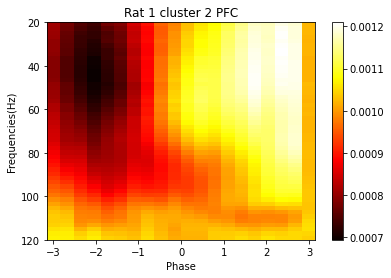

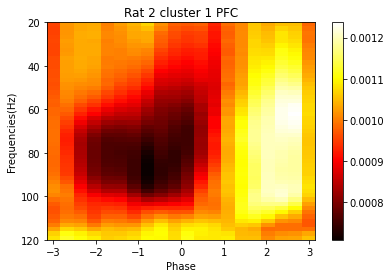

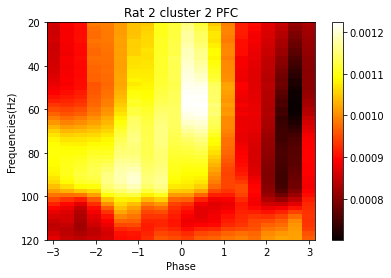

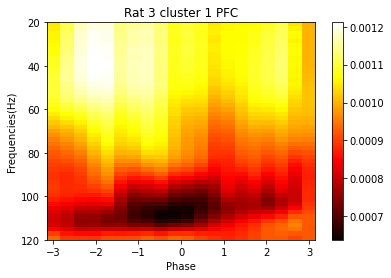

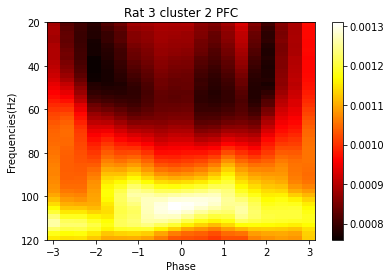

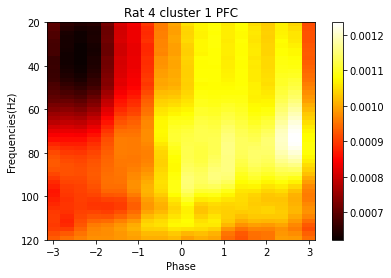

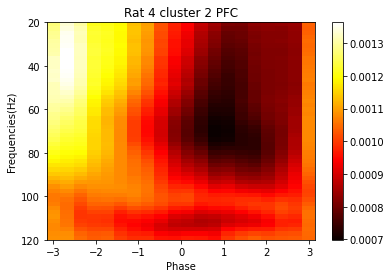

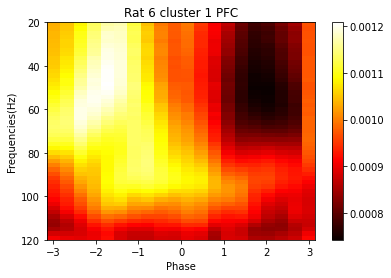

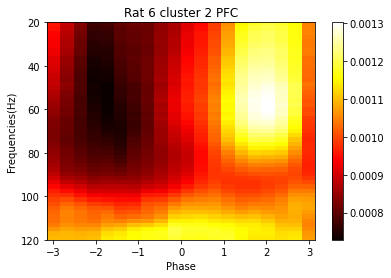

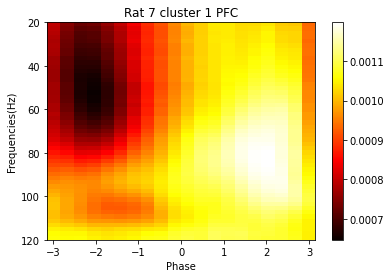

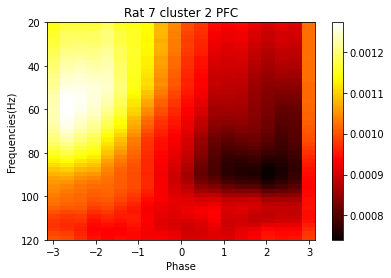

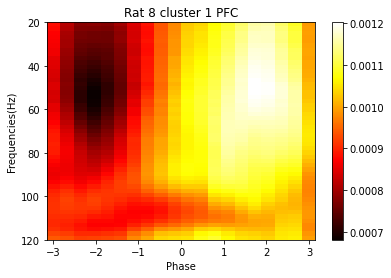

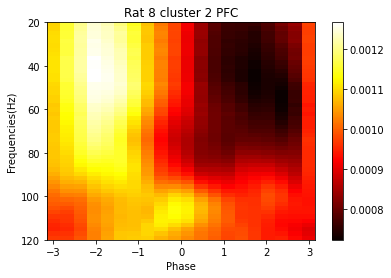

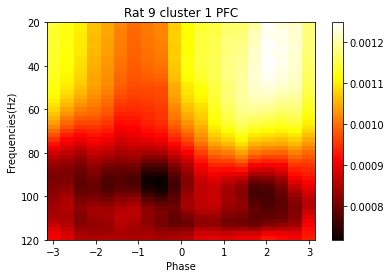

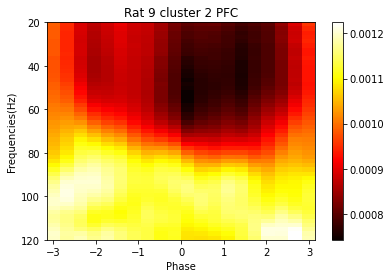

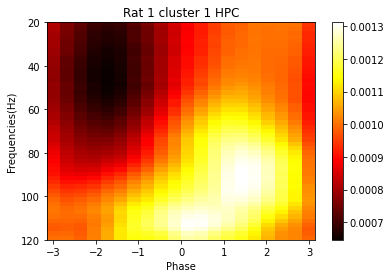

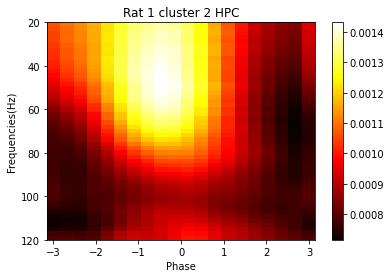

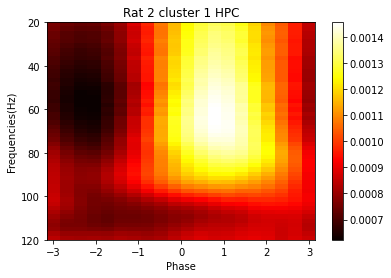

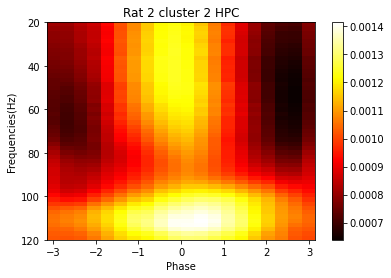

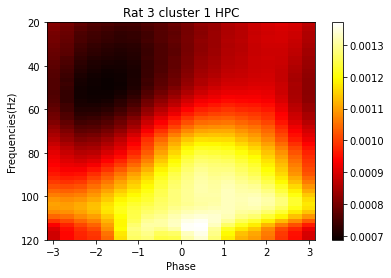

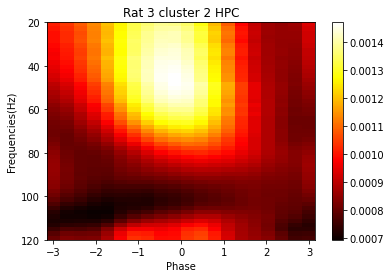

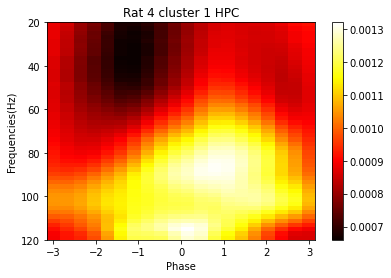

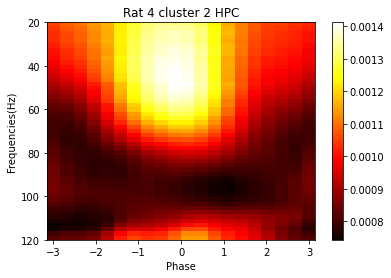

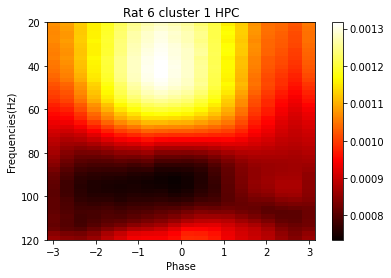

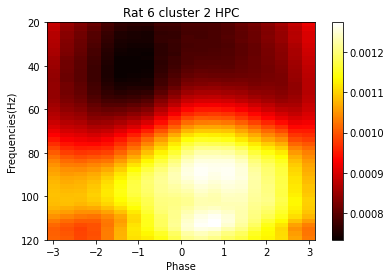

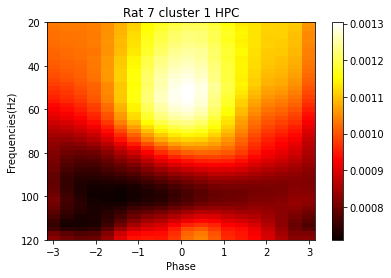

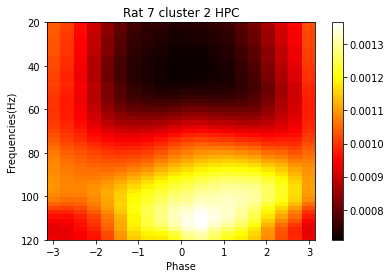

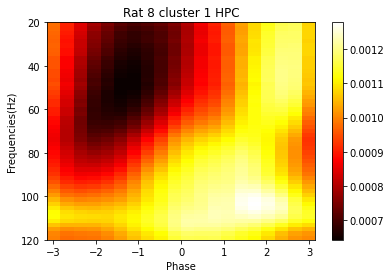

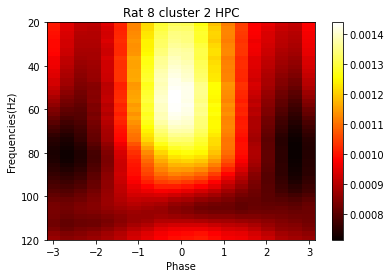

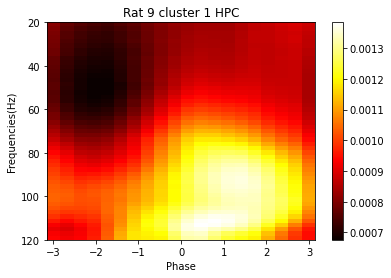

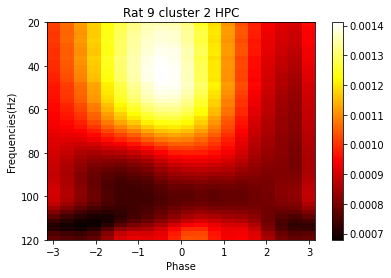

In [40]:
gamma_clusters_pfc,pfc_cluster_ex, pfc_cluster_in, mpfc_cluster_ex, mpfc_cluster_in,lr_pfc=gamma_sort(pls_pfc,  'PFC')
gamma_clusters_hpc,hpc_cluster_ex,hpc_cluster_in, mhpc_cluster_ex, mhpc_cluster_in,lr_hpc=gamma_sort(pls_hpc,  'HPC')

In [34]:
df_clusters =  df(columns =['Rat', 'Cluster_Number','PFC_Clusters', 'HPC_Clusters', 'PFC_Gamma_Clusters', 'HPC_Gamma_Clusters'])
df_clusters['PFC_Clusters']= df_clusters['PFC_Clusters'].astype(object)
df_clusters['HPC_Clusters']= df_clusters['HPC_Clusters'].astype(object)
df_clusters['PFC_Gamma_Clusters']= df_clusters['PFC_Gamma_Clusters'].astype(object)
df_clusters['HPC_Gamma_Clusters']= df_clusters['HPC_Gamma_Clusters'].astype(object)
for i in range(0,8):
    j=i+1
    if j >= 5:
        j+=1
    for num in range(len(gamma_clusters_hpc[i])):
        hpc_extra = hpc_cluster_ex[i][num]
        hpc_intra =hpc_cluster_in[i][num]
        pfc_extra =pfc_cluster_ex[i][num]
        pfc_intra = pfc_cluster_in[i][num]
        m_hpc_extra = mhpc_cluster_ex[i][num]
        m_hpc_intra =mhpc_cluster_in[i][num]
        m_pfc_extra =mpfc_cluster_ex[i][num]
        m_pfc_intra = mpfc_cluster_in[i][num]
        lr_hpc_extra = lr_hpc[i][num]
        lr_pfc_extra =lr_pfc[i][num]
        df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
                                        'PearsonDistance_PFC_Inter_cluster':pfc_extra,'PearsonDistance_HPC_Intra_Cluster': hpc_intra, \
                                        'PearsonDistance_HPC_Inter_cluster':hpc_extra,'MahalanobisDistance_PFC_Intra_Cluster': m_pfc_intra,\
                                        'MahalanobisDistance_PFC_Inter_cluster':m_pfc_extra,'MahalanobisDistance_HPC_Intra_Cluster': m_hpc_intra, \
                                        'MahalanobisDistance_HPC_Inter_cluster':m_hpc_extra,'LRatio_PFC':lr_pfc_extra,'LRatio_HPC':lr_hpc_extra,'PFC_Clusters':pfc_clusters[i][num], 'HPC_Clusters': hpc_clusters[i][num], \
                                        'PFC_Gamma_Clusters':gamma_clusters_pfc[i][num], 'HPC_Gamma_Clusters':gamma_clusters_hpc[i][num]}, ignore_index=True)

/tmp/ipykernel_4000/2159226497.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_4000/2159226497.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_4000/2159226497.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_4000/2159226497.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [35]:
df_clusters.to_csv('freq120/kmeans/mean/Clustersk_120_2_max.csv')

In [20]:
df_clusters

,Rat,Cluster_Number,PFC_Clusters,HPC_Clusters,PFC_Gamma_Clusters,HPC_Gamma_Clusters,LRatio_HPC,LRatio_PFC,MahalanobisDistance_HPC_Inter_cluster,MahalanobisDistance_HPC_Intra_Cluster,MahalanobisDistance_PFC_Inter_cluster,MahalanobisDistance_PFC_Intra_Cluster,PearsonDistance_HPC_Inter_cluster,PearsonDistance_HPC_Intra_Cluster,PearsonDistance_PFC_Inter_cluster,PearsonDistance_PFC_Intra_Cluster
0,1,1,"[1, 7, 8, 9, 10, 11, 14, 18, 26, 27, 29, 30, 3...","[1, 4, 5, 7, 9, 11, 12, 16, 18, 19, 21, 23, 25...","[[0.001052713080227247, 0.0010111642545410126,...","[[0.0011091837884722967, 0.0010775346741955414...",0.017764,0.021612,18.172160,6.063202,25.851961,5.428719,0.996797,0.976817,0.963772,0.493971
1,1,2,"[0, 2, 3, 4, 5, 6, 12, 13, 15, 16, 17, 19, 20,...","[0, 2, 3, 6, 8, 10, 13, 14, 15, 17, 20, 22, 24...","[[0.0009482058020914686, 0.0008669632946323778...","[[0.0009545752615724111, 0.000988715568942522,...",0.016479,0.012207,9.472781,6.771634,12.335342,7.564516,0.998890,0.980506,0.928379,0.495992
2,2,1,"[2, 5, 6, 13, 14, 16, 18, 19, 20, 21, 22, 26, ...","[4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 23, 26,...","[[0.0008634819773272796, 0.000775163887722346,...","[[0.0008492817894823402, 0.0009312488429100454...",0.001110,0.000043,11.499263,7.901479,23.815203,5.695478,0.979284,0.817996,0.979391,0.907335
3,2,2,"[0, 1, 3, 4, 7, 8, 9, 10, 11, 12, 15, 17, 23, ...","[0, 1, 2, 3, 11, 13, 14, 16, 18, 19, 21, 22, 2...","[[0.0009078284651030449, 0.0009002553397976303...","[[0.0009719979933980903, 0.0009718469161251652...",0.001237,0.006316,27.947239,6.725997,8.402179,8.309708,0.990510,0.692529,0.993769,0.681079
4,3,1,"[4, 9, 13, 15, 16, 17, 25, 27, 38, 41, 43, 45,...","[2, 4, 8, 9, 10, 11, 13, 15, 19, 20, 26, 29, 3...","[[0.0009402925841430554, 0.0008903130648275484...","[[0.001107666165215327, 0.001120455720006245, ...",0.037423,0.000280,13.955171,6.853031,98.995132,6.390027,0.994508,0.931590,0.985972,0.923568
5,3,2,"[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 14, 18, 1...","[0, 1, 3, 5, 6, 7, 12, 14, 16, 17, 18, 21, 22,...","[[0.0011178078281029913, 0.0011082171382062293...","[[0.0009346710822789777, 0.0008873388838640006...",0.000552,0.000277,13.968202,5.059231,9.405919,15.335247,0.983232,0.955906,0.989020,0.743045
6,4,1,"[1, 2, 3, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18,...","[0, 1, 6, 7, 8, 11, 13, 14, 17, 19, 21, 23, 27...","[[0.0011456045322020471, 0.0011062598376958513...","[[0.0011164155687791936, 0.0011912346553645098...",0.003539,0.000319,10.922089,8.135448,16.142884,4.901033,0.993992,0.844712,0.995883,0.892239
7,4,2,"[0, 4, 5, 8, 11, 16, 20, 23, 24, 25, 26, 28, 2...","[2, 3, 4, 5, 9, 10, 12, 15, 16, 18, 20, 22, 24...","[[0.0009098377068602236, 0.0008845089353084053...","[[0.0008634214305521401, 0.0008052855780566791...",0.027470,0.002683,17.209165,5.428172,8.733122,8.156834,0.979079,0.944267,0.947295,0.898865
8,6,1,"[0, 1, 2, 6, 8, 10, 12, 13, 15, 16, 17, 19, 20...","[1, 2, 4, 5, 6, 7, 8, 11, 17, 22, 23, 26, 28, ...","[[0.0009391872526684806, 0.0009118926795527263...","[[0.0009958642995787257, 0.0009679696936100798...",0.007919,0.000147,13.812951,6.120384,10.354766,9.411292,0.837599,0.425259,0.995215,0.974480
9,6,2,"[3, 4, 5, 7, 9, 11, 14, 18, 21, 23, 25, 27, 29...","[0, 3, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, ...","[[0.0010062519928020867, 0.000990538575950967,...","[[0.001004135870516396, 0.0009734681592436037,...",0.019307,0.001163,15.032715,6.561740,33.605141,6.598973,0.971099,0.513847,0.995891,0.966979
